# Exercise 6 — Custom Dataset (Dogs vs Cats)
Pontillas, Dorado

## 1) Imports and environment check

In [1]:
import os, glob, shutil, random, zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.1


## 2) Download the dataset with KaggleHub
Dataset: `moazeldsokyx/dogs-vs-cats`

In [3]:
# If you already downloaded with KaggleHub, set the path directly
download_path = r"C:\Users\acer\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1"
print('Using existing download at:', download_path)

# Quick peek a few levels deep
import os
levels_to_show = 3
for root, dirs, files in os.walk(download_path):
    depth = root.count(os.sep) - download_path.count(os.sep)
    if depth > levels_to_show:
        continue
    print(f"DIR: {root} | files: {len(files)} | subdirs: {len(dirs)}")

# Wire directories directly to dataset/train and dataset/test so we avoid copying
train_dir = os.path.join(download_path, 'dataset', 'train')
test_dir  = os.path.join(download_path, 'dataset', 'test')
val_dir   = os.path.join(download_path, 'dataset', 'validation')  # optional, not used by default
print('train_dir:', train_dir)
print('test_dir :', test_dir)
print('val_dir  :', val_dir)

Using existing download at: C:\Users\acer\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1
DIR: C:\Users\acer\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1 | files: 0 | subdirs: 1
DIR: C:\Users\acer\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1\dataset | files: 0 | subdirs: 3
DIR: C:\Users\acer\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1\dataset\test | files: 0 | subdirs: 2
DIR: C:\Users\acer\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1\dataset\test\cats | files: 6242 | subdirs: 0
DIR: C:\Users\acer\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1\dataset\test\dogs | files: 6219 | subdirs: 0
DIR: C:\Users\acer\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1\dataset\train | files: 0 | subdirs: 2
DIR: C:\Users\acer\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1\dataset\train\cats | files: 10000 | subdirs: 0
DIR: C:\Users\acer\.cache\kagglehub\datasets\moazelds

## 3) Organize into train/test folders (cats/dogs)
We'll create a working directory `dogs_vs_cats_data/` with:
- train/cat, train/dog
- test/cat, test/dog

In [ ]:
# 3.1) Unzip any archives found (common in Kaggle datasets)
def unzip_all_in(path, dest):
    os.makedirs(dest, exist_ok=True)
    for f in glob.glob(os.path.join(path, '**', '*.zip'), recursive=True):
        out_dir = os.path.join(dest, os.path.splitext(os.path.basename(f))[0])
        os.makedirs(out_dir, exist_ok=True)
        try:
            with zipfile.ZipFile(f, 'r') as z:
                z.extractall(out_dir)
            print('Extracted:', f, '->', out_dir)
        except zipfile.BadZipFile:
            print('Skipping bad zip:', f)

WORK_ROOT = os.path.abspath('dogs_vs_cats_data')
UNZIP_ROOT = os.path.join(WORK_ROOT, 'unzipped')
unzip_all_in(download_path, UNZIP_ROOT)

# 3.2) Collect images from both the original download path and unzipped path
def collect_images(*roots):
    imgs = []
    exts = ('*.jpg','*.jpeg','*.png','*.bmp')
    for r in roots:
        if not os.path.isdir(r):
            continue
        for e in exts:
            imgs.extend(glob.glob(os.path.join(r, '**', e), recursive=True))
    return imgs

all_images = collect_images(download_path, UNZIP_ROOT)
print('Found images:', len(all_images))

# 3.3) Build labeled lists
cats, dogs = [], []
for p in all_images:
    name = os.path.basename(p).lower()
    if 'cat' in name:
        cats.append(p)
    elif 'dog' in name:
        dogs.append(p)

print('cat imgs:', len(cats), '| dog imgs:', len(dogs))

# 3.4) Split 80/20 into train/test and copy files
random.seed(42)
def split_and_copy(files, train_dst, test_dst, split=0.8):
    os.makedirs(train_dst, exist_ok=True)
    os.makedirs(test_dst, exist_ok=True)
    files = files.copy()
    random.shuffle(files)
    n_train = int(len(files) * split)
    train_files = files[:n_train]
    test_files  = files[n_train:]
    for src in train_files:
        shutil.copy2(src, os.path.join(train_dst, os.path.basename(src)))
    for src in test_files:
        shutil.copy2(src, os.path.join(test_dst, os.path.basename(src)))
    return len(train_files), len(test_files)

train_cat = os.path.join(WORK_ROOT, 'train', 'cat')
train_dog = os.path.join(WORK_ROOT, 'train', 'dog')
test_cat  = os.path.join(WORK_ROOT, 'test',  'cat')
test_dog  = os.path.join(WORK_ROOT, 'test',  'dog')

ntr_c, nte_c = split_and_copy(cats, train_cat, test_cat, split=0.8)
ntr_d, nte_d = split_and_copy(dogs, train_dog, test_dog, split=0.8)
print(f'train cats: {ntr_c}, test cats: {nte_c}')
print(f'train dogs: {ntr_d}, test dogs: {nte_d}')

train_dir = os.path.join(WORK_ROOT, 'train')
test_dir  = os.path.join(WORK_ROOT, 'test')
print('Prepared dataset root:', WORK_ROOT)

## 4) Data generators (with augmentation)

In [7]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Use local folders created in the project (junctions to Kaggle cache)
import os
train_dir = os.path.abspath('train')
test_dir  = os.path.abspath('test')
print('train_dir:', train_dir)
print('test_dir :', test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
print('Classes:', train_gen.class_indices)

train_dir: c:\Users\acer\Documents\VSCode\ANN Activities\Exercise 6\train
test_dir : c:\Users\acer\Documents\VSCode\ANN Activities\Exercise 6\test
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 11844 images belonging to 2 classes.
Found 11844 images belonging to 2 classes.
Classes: {'cat': 0, 'dog': 1}
Classes: {'cat': 0, 'dog': 1}


## 5) Simple CNN with L2 and dropout

In [5]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                    kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

c:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,185 (24.86 MB)

 Trainable params: 6,516,737 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

## 6) Compile and train

c:\Users\acer\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5924 - loss: 1.5950

500/500 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.6235 - loss: 0.9189 - val_accuracy: 0.6190 - val_loss: 0.7478
Epoch 2/12
Epoch 2/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 353s 705ms/step - accuracy: 0.6679 - loss: 0.6851 - val_accuracy: 0.5207 - val_loss: 1.8216
Epoch 3/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 353s 705ms/step - accuracy: 0.6679 - loss: 0.6851 - val_accuracy: 0.5207 - val_loss: 1.8216
Epoch 3/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.6857 - loss: 0.6795

500/500 ━━━━━━━━━━━━━━━━━━━━ 340s 680ms/step - accuracy: 0.6984 - loss: 0.6747 - val_accuracy: 0.7345 - val_loss: 0.6208
Epoch 4/12
Epoch 4/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 354s 708ms/step - accuracy: 0.7388 - loss: 0.6300 - val_accuracy: 0.7057 - val_loss: 0.7865
Epoch 5/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 354s 708ms/step - accuracy: 0.7388 - loss: 0.6300 - val_accuracy: 0.7057 - val_loss: 0.7865
Epoch 5/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 356s 712ms/step - accuracy: 0.7491 - loss: 0.6294 - val_accuracy: 0.7495 - val_loss: 0.6345
Epoch 6/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 356s 712ms/step - accuracy: 0.7491 - loss: 0.6294 - val_accuracy: 0.7495 - val_loss: 0.6345
Epoch 6/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.7787 - loss: 0.5968

500/500 ━━━━━━━━━━━━━━━━━━━━ 347s 694ms/step - accuracy: 0.7843 - loss: 0.5825 - val_accuracy: 0.7465 - val_loss: 0.6099
Epoch 7/12
Epoch 7/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 341s 682ms/step - accuracy: 0.7876 - loss: 0.5931 - val_accuracy: 0.6118 - val_loss: 1.3217
Epoch 8/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 341s 682ms/step - accuracy: 0.7876 - loss: 0.5931 - val_accuracy: 0.6118 - val_loss: 1.3217
Epoch 8/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 346s 691ms/step - accuracy: 0.8088 - loss: 0.5739 - val_accuracy: 0.6445 - val_loss: 0.8214
Epoch 9/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 346s 691ms/step - accuracy: 0.8088 - loss: 0.5739 - val_accuracy: 0.6445 - val_loss: 0.8214
Epoch 9/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 350s 700ms/step - accuracy: 0.8101 - loss: 0.5609 - val_accuracy: 0.7303 - val_loss: 0.6703
Epoch 10/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 350s 700ms/step - accuracy: 0.8101 - loss: 0.5609 - val_accuracy: 0.7303 - val_loss: 0.6703
Epoch 10/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8177 -

500/500 ━━━━━━━━━━━━━━━━━━━━ 341s 682ms/step - accuracy: 0.8227 - loss: 0.5559 - val_accuracy: 0.8220 - val_loss: 0.5505
Epoch 11/12
Epoch 11/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 347s 694ms/step - accuracy: 0.8254 - loss: 0.5900 - val_accuracy: 0.8213 - val_loss: 0.6050
Epoch 12/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 347s 694ms/step - accuracy: 0.8254 - loss: 0.5900 - val_accuracy: 0.8213 - val_loss: 0.6050
Epoch 12/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 337s 674ms/step - accuracy: 0.8364 - loss: 0.6048 - val_accuracy: 0.8370 - val_loss: 0.5891
500/500 ━━━━━━━━━━━━━━━━━━━━ 337s 674ms/step - accuracy: 0.8364 - loss: 0.6048 - val_accuracy: 0.8370 - val_loss: 0.5891


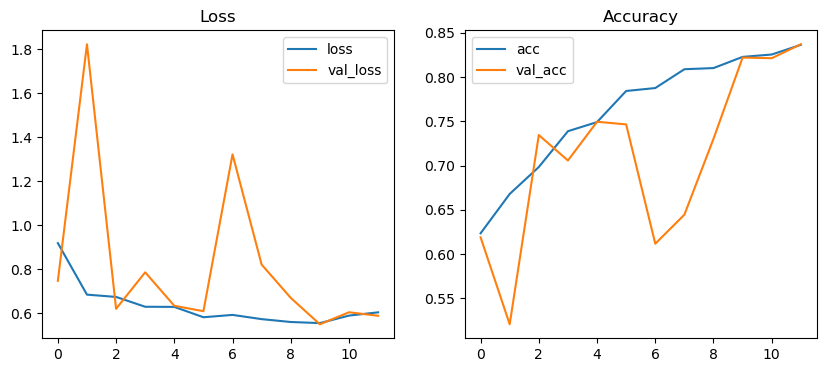

In [8]:
LASTNAME = 'Pontillas'
MODEL_NAME = f'exercise_6_custom_{LASTNAME.lower()}.h5'

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

EPOCHS = 12
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, save_best_only=True)
]

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history['loss'], label='loss'); plt.plot(history.history['val_loss'], label='val_loss'); plt.legend(); plt.title('Loss')
plt.subplot(1,2,2); plt.plot(history.history['accuracy'], label='acc'); plt.plot(history.history['val_accuracy'], label='val_acc'); plt.legend(); plt.title('Accuracy')
plt.show()

## 7) Evaluate accuracy on test set

In [9]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')

# Optional: classification report
test_gen.reset()
preds = model.predict(test_gen).ravel()
y_pred = (preds >= 0.5).astype(int)
y_true = test_gen.classes
target_names = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

371/371 ━━━━━━━━━━━━━━━━━━━━ 199s 536ms/step - accuracy: 0.8522 - loss: 0.4935
371/371 ━━━━━━━━━━━━━━━━━━━━ 199s 536ms/step - accuracy: 0.8522 - loss: 0.4935
Test Accuracy: 0.8522
Test Accuracy: 0.8522
371/371 ━━━━━━━━━━━━━━━━━━━━ 59s 154ms/step
371/371 ━━━━━━━━━━━━━━━━━━━━ 59s 154ms/step
              precision    recall  f1-score   support

         cat       0.85      0.87      0.86      6242
         dog       0.85      0.83      0.84      5602

    accuracy                           0.85     11844
   macro avg       0.85      0.85      0.85     11844
weighted avg       0.85      0.85      0.85     11844

              precision    recall  f1-score   support

         cat       0.85      0.87      0.86      6242
         dog       0.85      0.83      0.84      5602

    accuracy                           0.85     11844
   macro avg       0.85      0.85      0.85     11844
weighted avg       0.85      0.85      0.85     11844



## 8) Save model (ensures exact filename)

In [10]:
model.save(MODEL_NAME)
print('Saved model as', MODEL_NAME)

Saved model as exercise_6_custom_pontillas.h5


## 9) Quick predictions on two images
Set two paths (one cat, one dog) to test the model.

In [11]:
from tensorflow.keras.preprocessing import image
import glob, os, random


def predict_image(img_path, model_path=MODEL_NAME, target_size=IMG_SIZE):
    m = tf.keras.models.load_model(model_path)
    img = image.load_img(img_path, target_size=target_size)
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    pred = float(m.predict(arr)[0,0])  # probability of 'dog'
    label = 'dog' if pred >= 0.5 else 'cat'
    return label, pred


def pick_one_image(folder):
    exts = ('*.jpg','*.jpeg','*.png','*.bmp')
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, e)))
    if not files:
        return None
    return random.choice(files)

# Prefer test set, fallback to train set
cat_path = pick_one_image(os.path.join('test', 'cat')) or pick_one_image(os.path.join('train', 'cat'))
dog_path = pick_one_image(os.path.join('test', 'dog')) or pick_one_image(os.path.join('train', 'dog'))

print('Chosen sample files:')
print('  cat:', cat_path)
print('  dog:', dog_path)

if cat_path and os.path.exists(cat_path):
    label, conf = predict_image(cat_path)
    print(f"{cat_path} -> label: {label}, dog_confidence: {conf:.2f}")
else:
    print('No cat image found in test/cat or train/cat')

if dog_path and os.path.exists(dog_path):
    label, conf = predict_image(dog_path)
    print(f"{dog_path} -> label: {label}, dog_confidence: {conf:.2f}")
else:
    print('No dog image found in test/dog or train/dog')

Chosen sample files:
  cat: test\cat\cat (3218).jpg
  dog: test\dog\dog (360).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
test\cat\cat (3218).jpg -> label: cat, dog_confidence: 0.07
test\cat\cat (3218).jpg -> label: cat, dog_confidence: 0.07


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
test\dog\dog (360).jpg -> label: dog, dog_confidence: 0.98
test\dog\dog (360).jpg -> label: dog, dog_confidence: 0.98


## 11) Explore the saved `.h5` model file
Visualize the Keras model summary and browse the HDF5 structure (top-level groups, datasets, shapes).

In [14]:
import tensorflow as tf
import h5py, itertools, os, glob

# Prefer existing MODEL_NAME; otherwise try common names or discover .h5 in CWD
MODEL_NAME = globals().get('MODEL_NAME', None)
if not MODEL_NAME or not os.path.exists(MODEL_NAME):
    candidates = [
        'exercise_6_custom_pontillas.h5',
        'exercise_6_custom_pontillas-dorado.h5',
    ]
    for c in candidates:
        if os.path.exists(c):
            MODEL_NAME = c
            break
    if not MODEL_NAME:
        # last resort: pick the newest .h5 in current dir
        h5s = sorted(glob.glob('*.h5'), key=lambda p: os.path.getmtime(p), reverse=True)
        if h5s:
            MODEL_NAME = h5s[0]

if not MODEL_NAME or not os.path.exists(MODEL_NAME):
    raise FileNotFoundError('No .h5 model file found in current folder. Please set MODEL_NAME to your saved file path.')

# 1) Load via Keras and show a concise view
m = tf.keras.models.load_model(MODEL_NAME)
print('Loaded model:', MODEL_NAME)
print('\nModel summary:')
m.summary()

print('\nLayer weights (name -> shapes):')
for layer in m.layers[:8]:  # show a few to keep output readable
    shapes = [w.shape for w in layer.get_weights()]
    if shapes:
        print(f'  {layer.name}: {shapes}')

# 2) Inspect raw HDF5 structure (top-level + a few items)
with h5py.File(MODEL_NAME, 'r') as f:
    print('\nTop-level keys:', list(f.keys()))

    print('\nHDF5 structure (first ~30 items):')
    counter = itertools.count()
    def visitor(name, obj):
        i = next(counter)
        if i >= 30:
            return  # stop after ~30
        kind = 'Dataset' if isinstance(obj, h5py.Dataset) else 'Group'
        extra = ''
        if isinstance(obj, h5py.Dataset):
            try:
                extra = f' shape={obj.shape} dtype={obj.dtype}'
            except Exception:
                extra = ''
        print(f' - {kind}: {name}{extra}')
    f.visititems(visitor)

    # Show some common groups if present
    for grp_name in ['model_weights', 'optimizer_weights']:
        if grp_name in f:
            children = list(f[grp_name].keys())
            print(f'\nGroup: /{grp_name} -> children (first 10):', children[:10])


Loaded model: exercise_6_custom_pontillas-dorado.h5

Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,187 (24.86 MB)

 Trainable params: 6,516,737 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)


Layer weights (name -> shapes):
  conv2d: [(3, 3, 3, 32), (32,)]
  batch_normalization: [(32,), (32,), (32,), (32,)]
  conv2d_1: [(3, 3, 32, 64), (64,)]
  batch_normalization_1: [(64,), (64,), (64,), (64,)]

Top-level keys: ['model_weights', 'optimizer_weights']

HDF5 structure (first ~30 items):
 - Group: model_weights
 - Group: model_weights/batch_normalization
 - Group: model_weights/batch_normalization/sequential
 - Group: model_weights/batch_normalization/sequential/batch_normalization
 - Dataset: model_weights/batch_normalization/sequential/batch_normalization/beta shape=(32,) dtype=float32
 - Dataset: model_weights/batch_normalization/sequential/batch_normalization/gamma shape=(32,) dtype=float32
 - Dataset: model_weights/batch_normalization/sequential/batch_normalization/moving_mean shape=(32,) dtype=float32
 - Dataset: model_weights/batch_normalization/sequential/batch_normalization/moving_variance shape=(32,) dtype=float32
 - Group: model_weights/batch_normalization_1
 - Gro